**🧿Importing Required Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects
from linearmodels.panel import compare
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from scipy.stats import chi2
from scipy.stats import shapiro

**📍Loading The Dataset**

In [3]:
file_path = r"C:\Users\USER\Documents\Panel Data.xlsx"
df = pd.read_excel(file_path)
display(df.head())

,Years,Country,GDP,Exchange_Rate,Export,FDI,Inflation
0,1991,Seychelles,119732.861057,5.289308,4.756928e+09,4.916538,1.986755
1,1992,Seychelles,127733.811455,5.121983,4.490175e+09,1.953586,3.246753
2,1993,Seychelles,134236.181197,5.181533,4.807027e+09,3.735617,1.383648
3,1994,Seychelles,127520.312647,5.055858,4.488623e+09,5.938640,1.736973
4,1995,Seychelles,126268.751992,4.761975,4.547939e+09,8.485578,-0.243902


**Data Checking🧿**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Years          374 non-null    int64  
 1   Country        374 non-null    object 
 2   GDP            374 non-null    float64
 3   Exchange_Rate  374 non-null    float64
 4   Export         331 non-null    float64
 5   FDI            358 non-null    float64
 6   Inflation      360 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 20.6+ KB


In [5]:
df.columns

Index(['Years', 'Country', 'GDP', 'Exchange_Rate', 'Export', 'FDI',
       'Inflation'],
      dtype='object')

In [6]:
df.shape

(374, 7)

In [7]:
df.isnull().sum()

Years             0
Country           0
GDP               0
Exchange_Rate     0
Export           43
FDI              16
Inflation        14
dtype: int64

**Exploratory Data Analysis📊**

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Years,374.0,2.007500e+03,9.823851e+00,1.991000e+03,1.999000e+03,2.007500e+03,2.016000e+03,2.024000e+03
GDP,374.0,6.693334e+05,1.266117e+06,9.159879e+03,6.175043e+04,1.702742e+05,3.386327e+05,6.604113e+06
Exchange_Rate,374.0,1.216949e+02,2.027143e+02,2.807283e-01,6.829702e+00,2.366903e+01,9.320774e+01,7.323977e+02
Export,331.0,8.159977e+11,1.233347e+12,4.488623e+09,5.222249e+10,1.495603e+11,1.269008e+12,6.209336e+12
FDI,358.0,5.058220e+00,1.199532e+01,-6.897609e+00,6.973476e-01,2.382512e+00,5.546522e+00,1.618238e+02
Inflation,360.0,5.273813e+00,5.814774e+00,-1.168611e+01,2.428489e+00,4.377694e+00,6.909146e+00,3.696476e+01


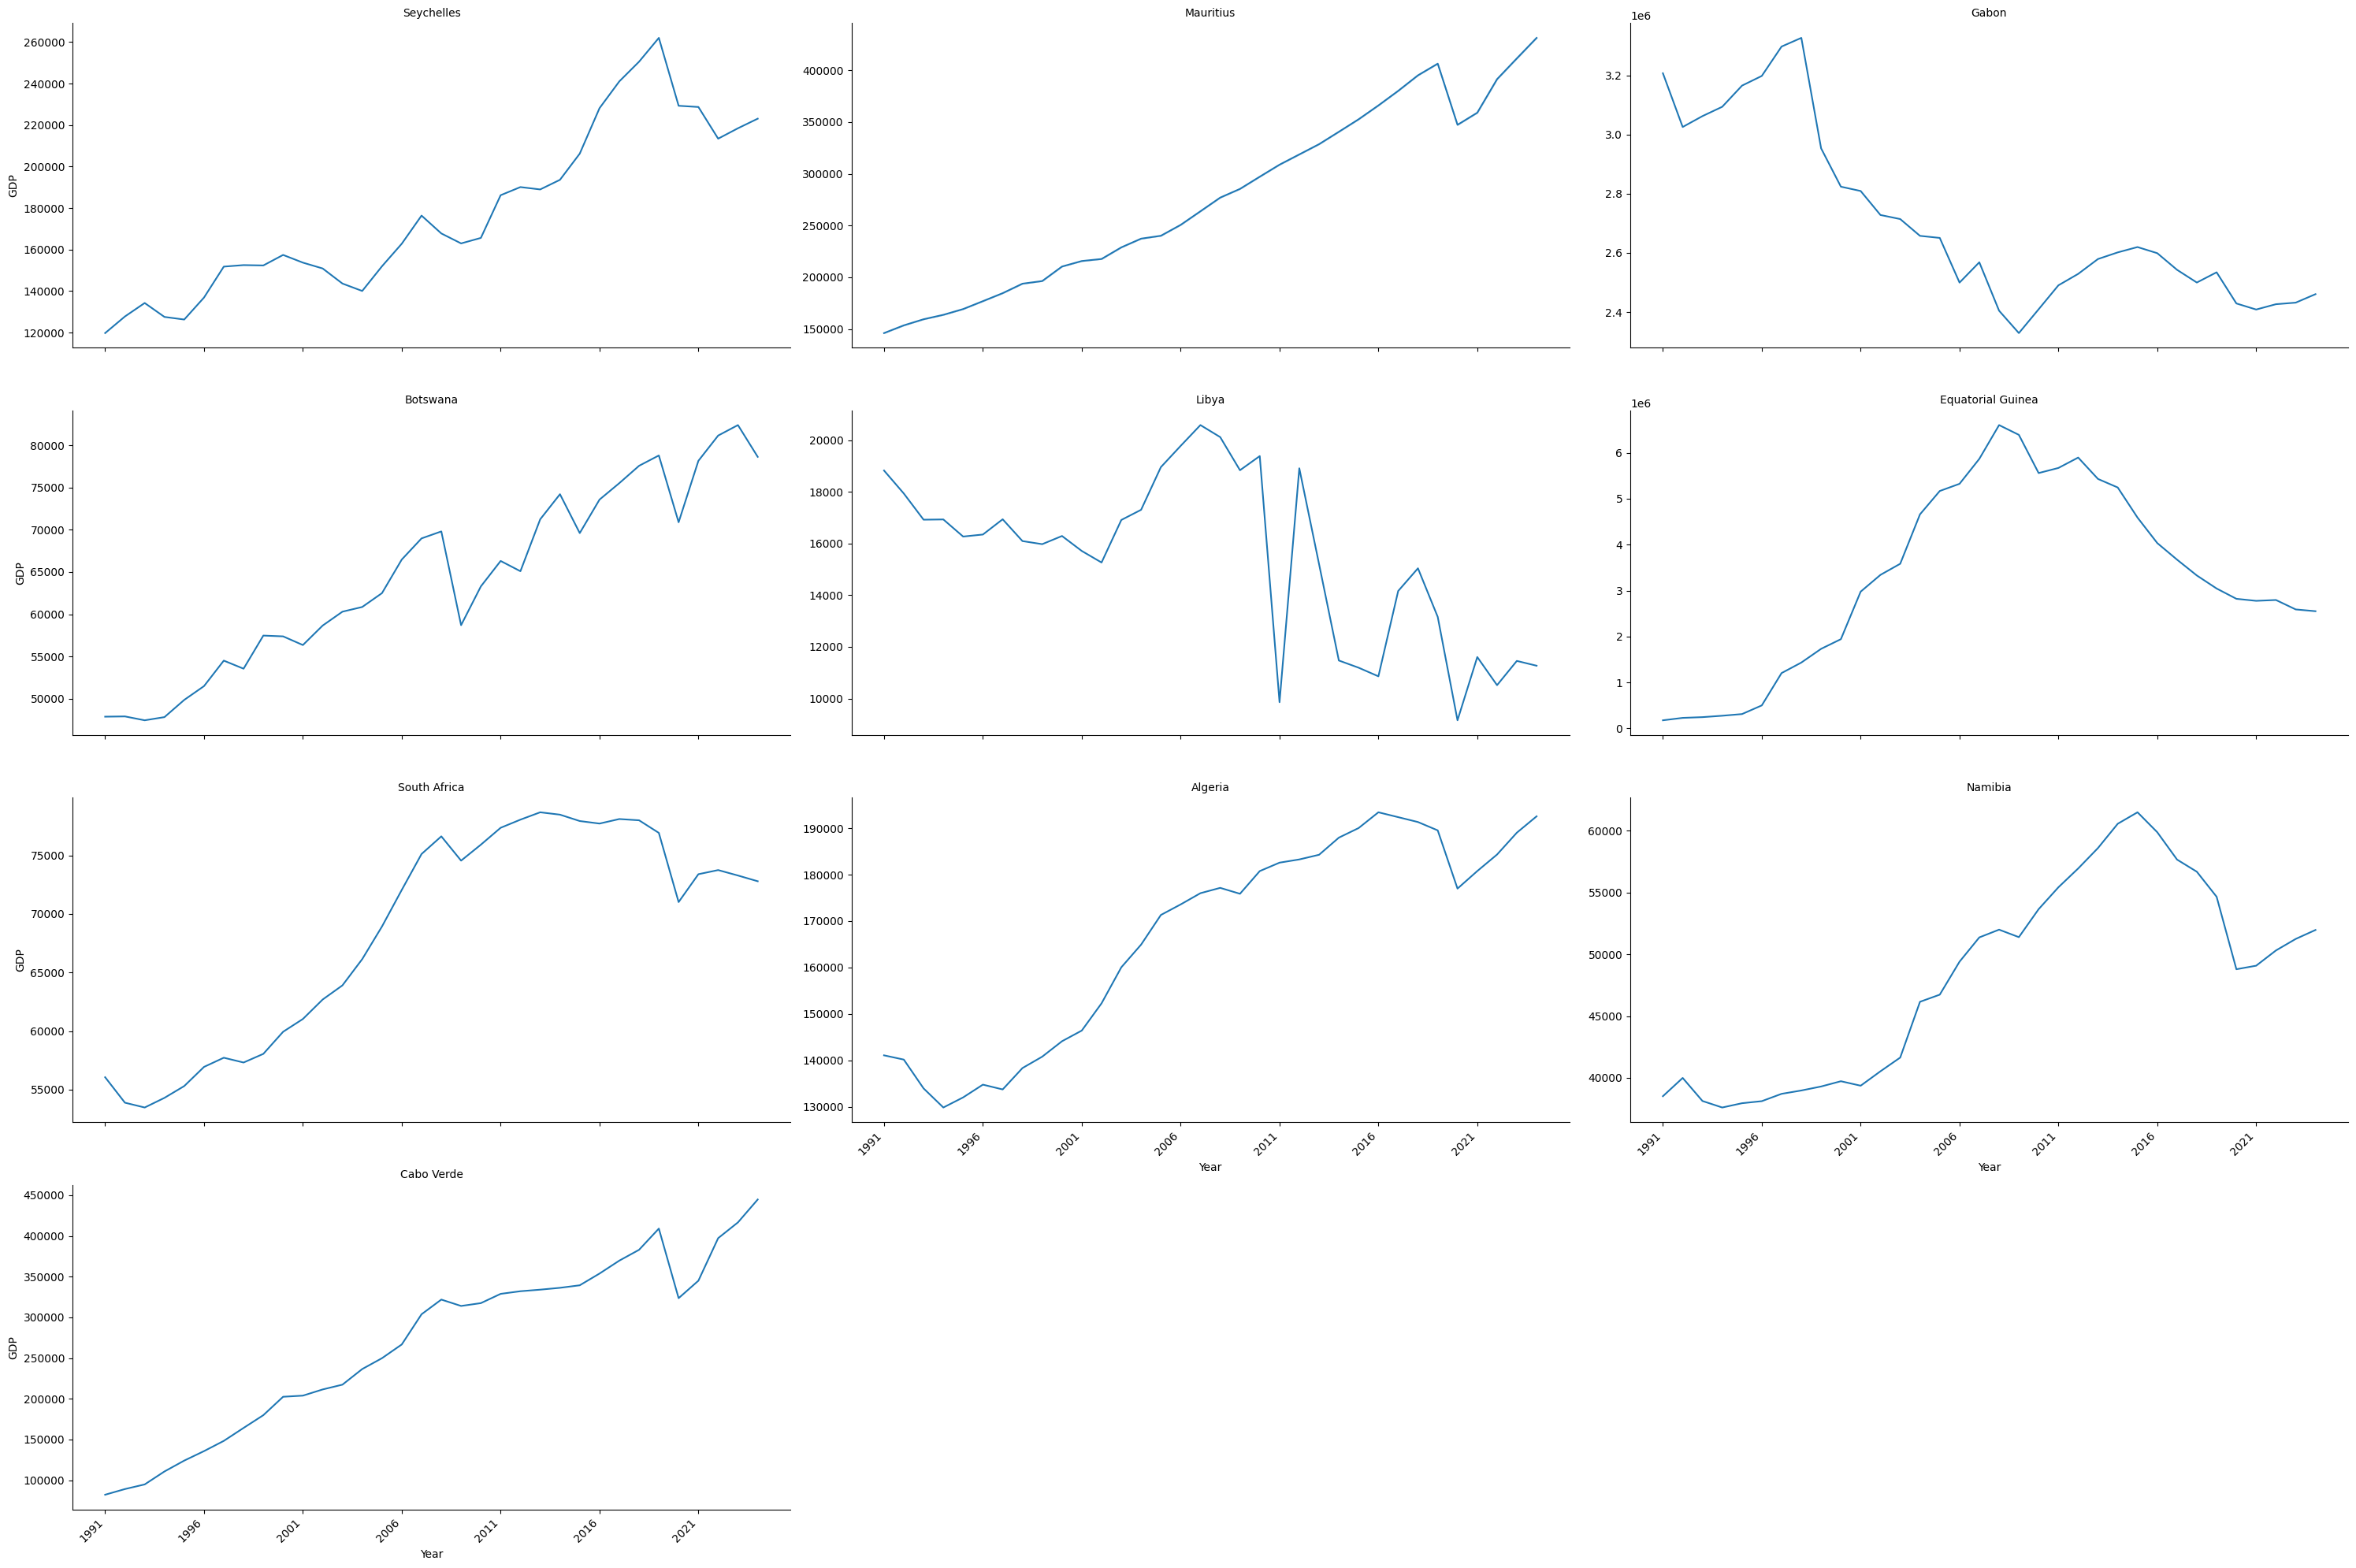

In [10]:
#Yearly Trend of GDP for each country

g = sns.FacetGrid(df, col="Country", col_wrap=3, height= 5, aspect = 2, sharey=False)

g.map_dataframe(sns.lineplot, x="Years", y="GDP")

year_ticks = np.arange(df['Years'].min(), df['Years'].max()+1, 5)  

g.set_titles("{col_name}")
g.set_axis_labels("Year", "GDP")

for ax in g.axes.flatten():
    ax.set_xticks(year_ticks)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
        
plt.tight_layout()
plt.show()

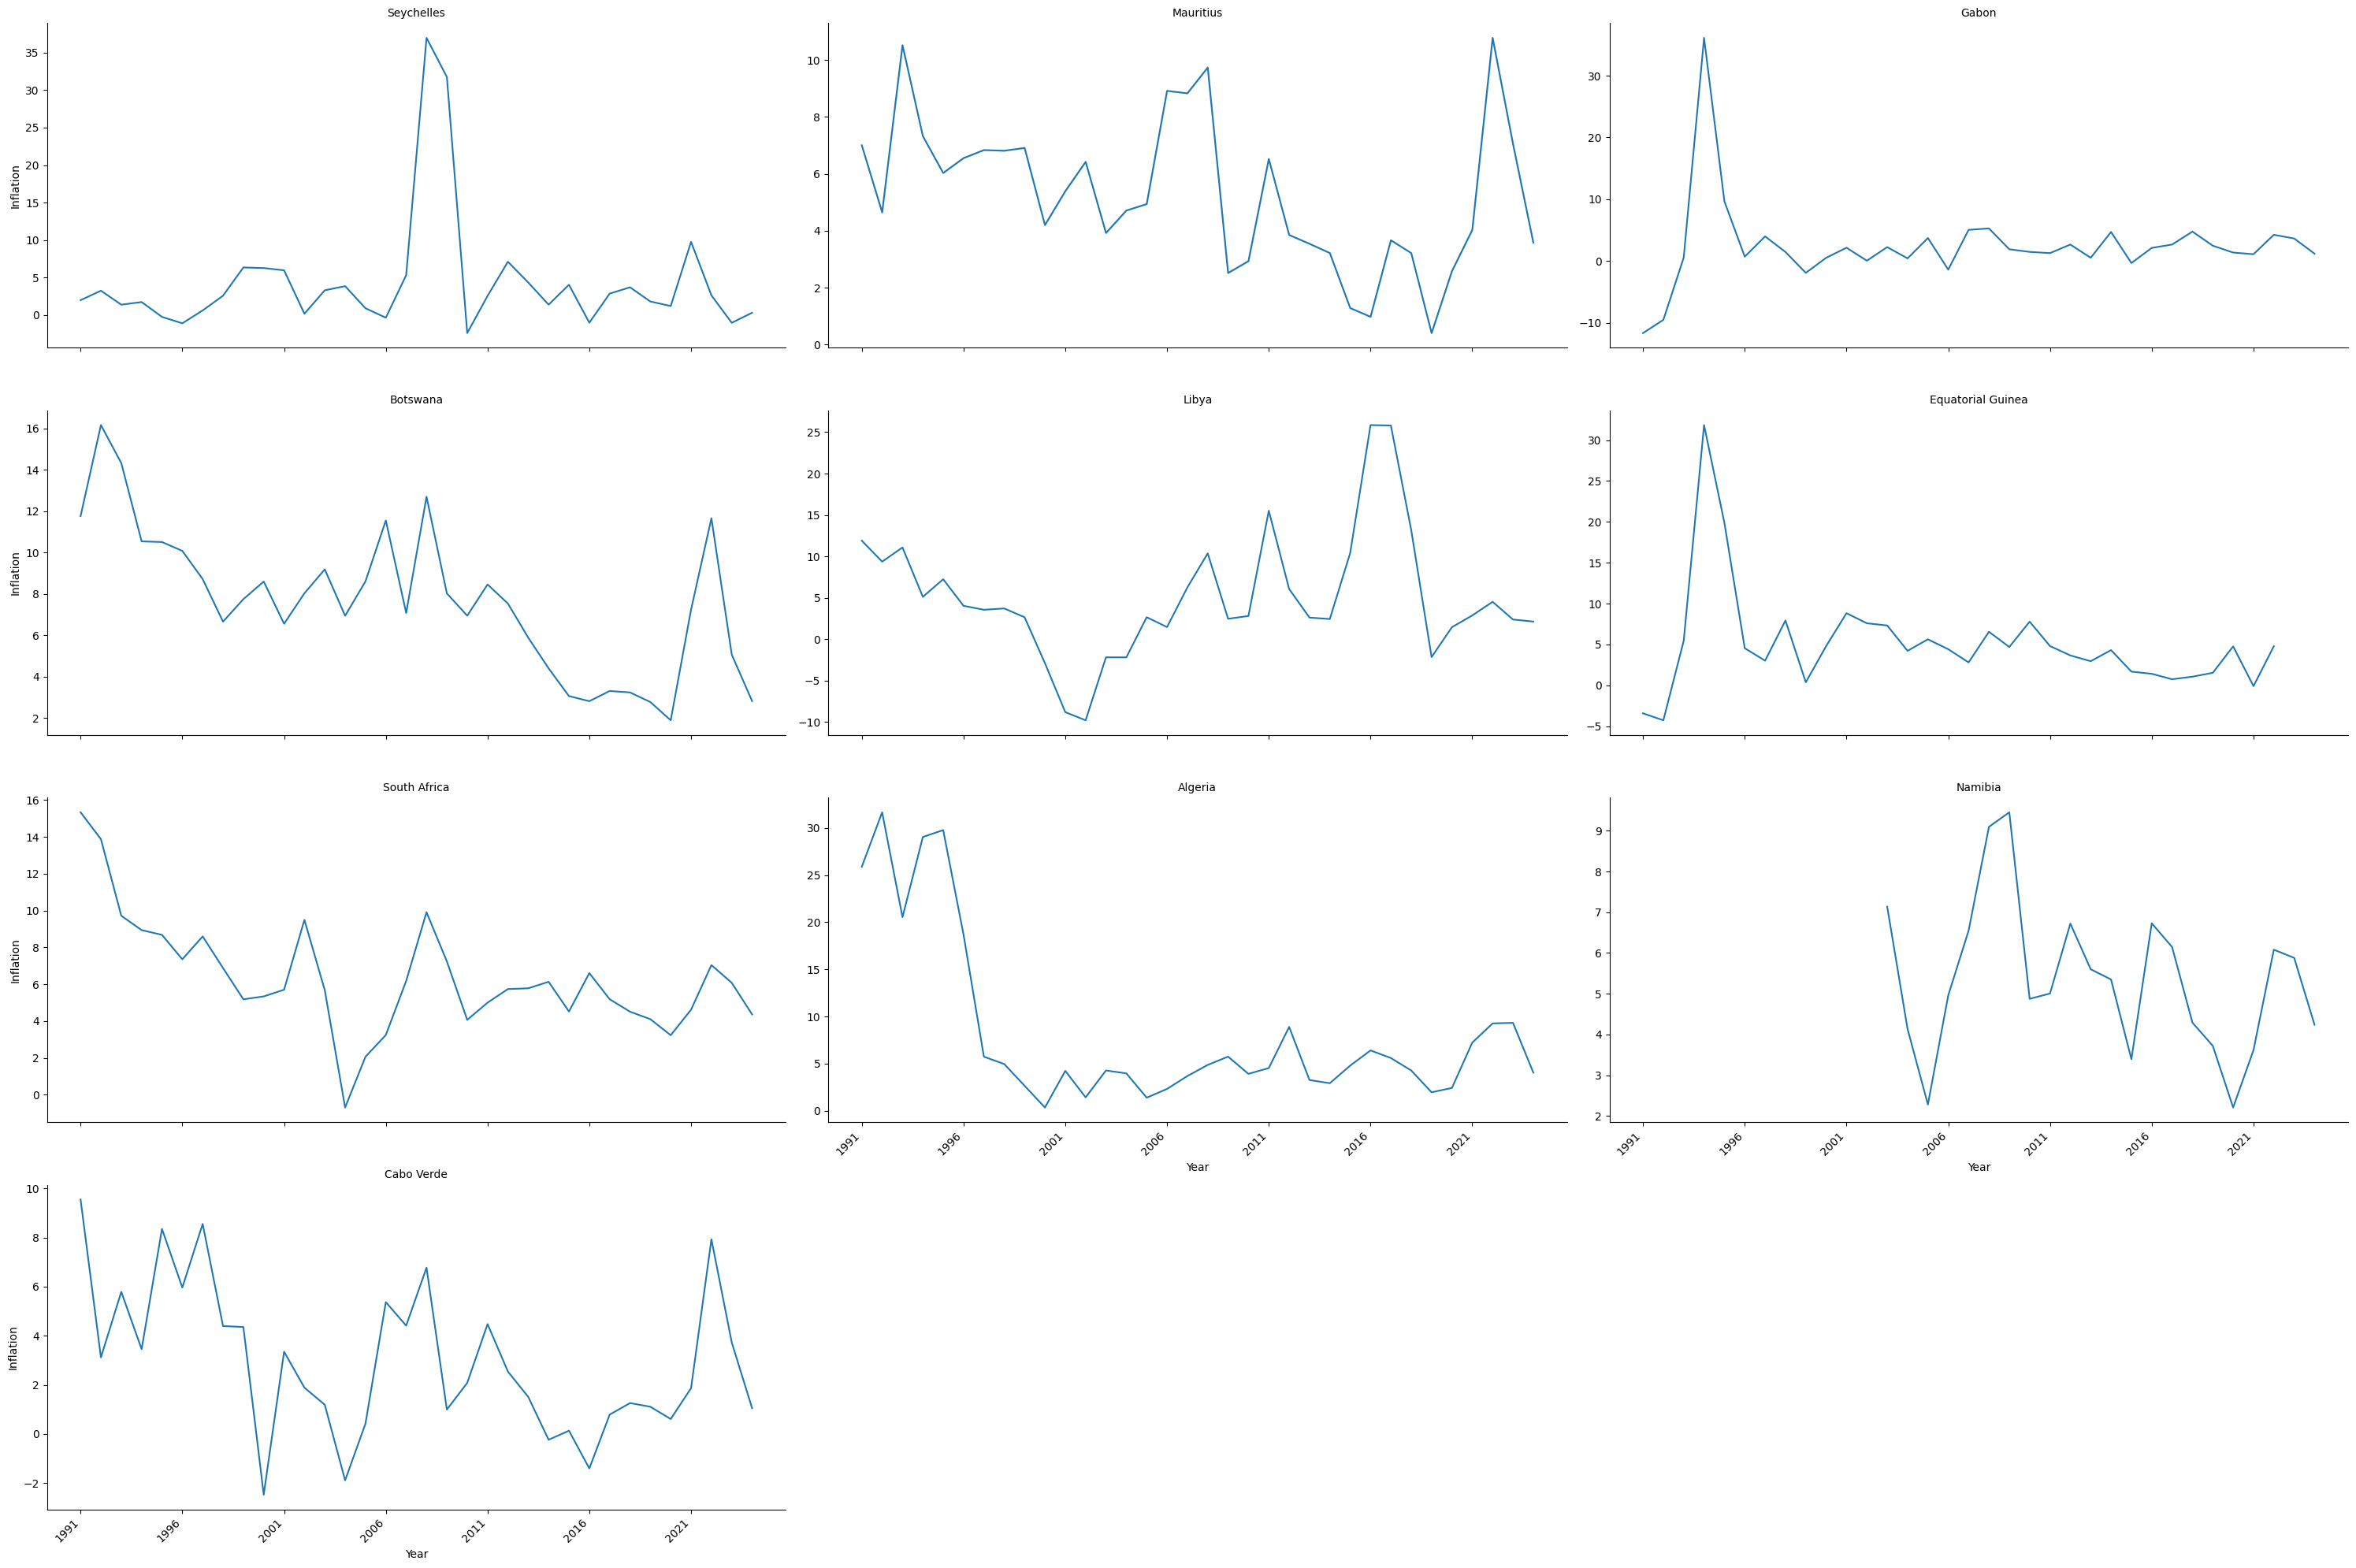

In [11]:
#Yearly trend of Inflation For Each Country

g = sns.FacetGrid(df, col="Country", col_wrap=3, height= 5, aspect = 2, sharey=False)

g.map_dataframe(sns.lineplot, x="Years", y="Inflation")

year_ticks = np.arange(df['Years'].min(), df['Years'].max()+1, 5)  

g.set_titles("{col_name}")
g.set_axis_labels("Year", "Inflation")

for ax in g.axes.flatten():
    ax.set_xticks(year_ticks)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')
        
plt.tight_layout()
plt.show()

**🔎Structuring Data As Panel**

In [12]:
panel_df = df.set_index(['Country', 'Years']).sort_index()
print(panel_df.head())

                         GDP  Exchange_Rate        Export       FDI  Inflation
Country Years                                                                 
Algeria 1991   141089.333809      18.472875  1.205386e+12  0.025459  25.886387
        1992   140173.466448      21.836075  1.252396e+12  0.062496  31.669662
        1993   133967.343625      23.345407  1.228601e+12  0.000002  20.540326
        1994   129856.544466      35.058501  1.186828e+12  0.000002  29.047656
        1995   132031.310675      47.662727  1.261598e+12  0.000002  29.779626


**📌Data Cleaning**

In [13]:
model_vars = ['GDP', 'Exchange_Rate', 'Export', 'FDI', 'Inflation']

# Dropping only rows with missing values in those variables

model_df = panel_df.dropna(subset=model_vars)

model_df_reset = model_df.reset_index()

In [14]:
#Creating New Dataframe After Dropping the Missing Rows

X = model_df[['Exchange_Rate', 'Export', 'FDI', 'Inflation']]
X = add_constant(X)

y = model_df['GDP']

**Assumptions Before Fitting The Model📈**

In [15]:
#Multicollinearity check

vif_data = pd.DataFrame()
vif_data["feature"] =  X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

         feature       VIF
0          const  3.187473
1  Exchange_Rate  3.121850
2         Export  3.022551
3            FDI  1.013545
4      Inflation  1.054570


In [16]:
#Stationarity Usind ADF Test

# Loop over each unit


for unit in panel_df.index.get_level_values('Country').unique():
    series = panel_df.loc[panel_df.index.get_level_values('Country') == unit, 'GDP'].dropna()
    result = adfuller(series)
    print(f"Unit {unit}: ADF p-value = {result[1]}")

Unit Algeria: ADF p-value = 0.8972265385983009
Unit Botswana: ADF p-value = 0.7065535183906402
Unit Cabo Verde: ADF p-value = 0.27882650819530175
Unit Equatorial Guinea: ADF p-value = 0.015041090408111165
Unit Gabon: ADF p-value = 0.510497233590698
Unit Libya: ADF p-value = 0.530810700238859
Unit Mauritius: ADF p-value = 0.9580824518541236
Unit Namibia: ADF p-value = 0.7029194018200433
Unit Seychelles: ADF p-value = 0.7481792718930033
Unit South Africa: ADF p-value = 0.6304085878135421


In [17]:
#1st Differencing

panel_df['GDP_diff'] = panel_df.groupby(level='Country')['GDP'].diff()

for unit in panel_df.index.get_level_values('Country').unique():
    series = panel_df.loc[panel_df.index.get_level_values('Country') == unit, 'GDP_diff'].dropna()
    result = adfuller(series)
    print(f"Unit {unit}: ADF p-value = {result[1]}")

Unit Algeria: ADF p-value = 0.0022754166520537193
Unit Botswana: ADF p-value = 1.1231540176851932e-07
Unit Cabo Verde: ADF p-value = 4.5013943953152377e-07
Unit Equatorial Guinea: ADF p-value = 0.6593382083845806
Unit Gabon: ADF p-value = 1.4035570885543329e-05
Unit Libya: ADF p-value = 6.8900467275273366e-15
Unit Mauritius: ADF p-value = 2.6252454140680557e-16
Unit Namibia: ADF p-value = 0.13534649640252905
Unit Seychelles: ADF p-value = 0.00012299331734561225
Unit South Africa: ADF p-value = 0.00025944154240182616


In [18]:
#2nd differencing

panel_df['GDP_diff2'] = panel_df.groupby(level='Country')['GDP_diff'].diff()

for unit in panel_df.index.get_level_values('Country').unique():
    series = panel_df.loc[panel_df.index.get_level_values('Country') == unit, 'GDP_diff2'].dropna()
    result = adfuller(series)
    print(f"Unit {unit}: ADF p-value = {result[1]}")


Unit Algeria: ADF p-value = 1.0950683230740257e-13
Unit Botswana: ADF p-value = 0.0013528930132070752
Unit Cabo Verde: ADF p-value = 0.008329251628474055
Unit Equatorial Guinea: ADF p-value = 7.64262750240975e-13
Unit Gabon: ADF p-value = 6.78730236917826e-08
Unit Libya: ADF p-value = 0.00010634449734415042
Unit Mauritius: ADF p-value = 5.698431231956353e-07
Unit Namibia: ADF p-value = 0.20029106319095313
Unit Seychelles: ADF p-value = 8.793191840832608e-05
Unit South Africa: ADF p-value = 0.4186036935732358


**Model Fitting📉**

In [19]:
#Fixed Effect Model

fixed_model = PanelOLS(y, X, entity_effects=True)
fixed_results = fixed_model.fit()
print(fixed_results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    GDP   R-squared:                        0.5623
Estimator:                   PanelOLS   R-squared (Between):              0.5454
No. Observations:                 303   R-squared (Within):               0.5623
Date:                Fri, Jul 18 2025   R-squared (Overall):              0.4684
Time:                        13:31:16   Log-likelihood                   -4153.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      92.815
Entities:                          10   P-value                           0.0000
Avg Obs:                       30.300   Distribution:                   F(4,289)
Min Obs:                       13.000                                           
Max Obs:                       66.000   F-statistic (robust):             92.815
                            

In [20]:
#Random Effect Model

random_model = RandomEffects(y, X)
random_results = random_model.fit()
print(random_results.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                    GDP   R-squared:                        0.5870
Estimator:              RandomEffects   R-squared (Between):              0.7443
No. Observations:                 303   R-squared (Within):               0.5446
Date:                Fri, Jul 18 2025   R-squared (Overall):              0.6669
Time:                        13:31:35   Log-likelihood                   -4178.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      105.89
Entities:                          10   P-value                           0.0000
Avg Obs:                       30.300   Distribution:                   F(4,298)
Min Obs:                       13.000                                           
Max Obs:                       66.000   F-statistic (robust):             103.71
                            

**🎯Hausman Test**

In [21]:
b_FE = fixed_results.params
b_RE = random_results.params

common_coef = b_FE.index.intersection(b_RE.index)

diff = b_FE[common_coef] - b_RE[common_coef]

cov_FE = fixed_results.cov
cov_RE = random_results.cov

cov_diff = cov_FE.loc[common_coef, common_coef] - cov_RE.loc[common_coef, common_coef]

stat = np.dot(diff.T, np.linalg.inv(cov_diff).dot(diff))

df = len(diff)
p_value = 1- chi2.cdf(stat, df)

print(f"Hausman Test Statistic: {stat:.4f}")
print(f"Degrees of Freedom: {df}")
print(f"P-value: {p_value:.4f}")

Hausman Test Statistic: 37.9353
Degrees of Freedom: 5
P-value: 0.0000


**📌Post Diagnostic Assumptions**

Shapiro-Wilk Test p-value: 1.2685528136779006e-19


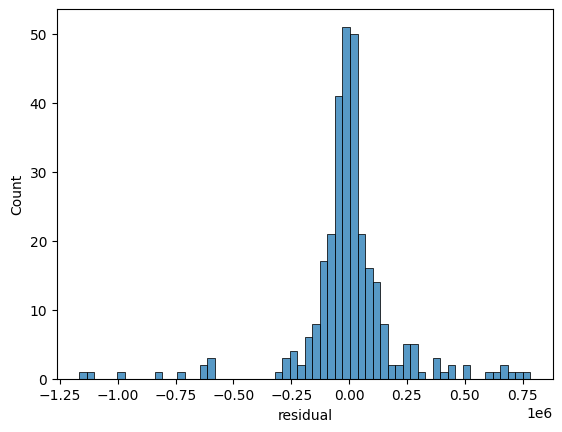

In [22]:
#Normality of Residuals

residuals = fixed_results.resids
sns.histplot(residuals)

#Shapiro Test

stat, p = shapiro(residuals)
print(f'Shapiro-Wilk Test p-value: {p}')

In [23]:
#Autocorrelation

from statsmodels.stats.stattools import durbin_watson

dw = durbin_watson(residuals)

print(dw)

0.374530293041251


In [26]:
fe_results = fixed_model.fit(cov_type='clustered', cluster_time=True)

print(fe_results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                    GDP   R-squared:                        0.5623
Estimator:                   PanelOLS   R-squared (Between):              0.5454
No. Observations:                 303   R-squared (Within):               0.5623
Date:                Fri, Jul 18 2025   R-squared (Overall):              0.4684
Time:                        13:54:31   Log-likelihood                   -4153.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      92.815
Entities:                          10   P-value                           0.0000
Avg Obs:                       30.300   Distribution:                   F(4,289)
Min Obs:                       13.000                                           
Max Obs:                       66.000   F-statistic (robust):             25.201
                            